In [5]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
# 비전할 때 쓰는 데이터, 라이브러리들 가지고 있는 모듈
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

################################
#      Discriminator 설계      #
################################

## vanila gan으로 만듦
# 어떤 분포를 만들고 분포를 바탕으로 이미지를 만듦
# d는 분포와 이미지 관계 학습해서 fake인지 아닌지 판별

class MNIST_Discriminator(nn.Module):

  # 생성자와 forward 함수 오바라이딩  
  def __init__(self, config):
    super(MNIST_Discriminator, self).__init__()

    # 입력층 노드 수
    self.inode = config["d_input_node"] 
    # 은닉층 노드 수
    self.hnode = config["d_hidden_node"] # input보다는 많음
    # 출력층 노드 수: 분류해야 하는 레이블 수
    self.onode = config["d_output_node"] 

    # 신경망 설계
    # hidden 계속 확장
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Sigmoid()) # 0 or 1 -> real이냐 fake냐
    
  def forward(self, input_features):
    hypothesis = self.net(input_features) # hypothesis 생성
    return hypothesis

################################
#        Generator 설계        #
################################

class MNIST_Generator(nn.Module):

  # 생성자와 forward 함수 오바라이딩
  def __init__(self, config):
    super(MNIST_Generator, self).__init__()

    # 입력층 노드 수
    self.inode = config["g_input_node"] # z(예측한 분포)의 사이즈 28x28보다 작은 값이 들어옴
    # 은닉층 노드 수
    self.hnode = config["g_hidden_node"] 
    # 출력층 노드 수: 생성해야 하는 노드 수
    self.onode = config["g_output_node"] # 28x28 (이미지 생성해야 하므로)

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True), # self.onode == 28x28
                             nn.Tanh()) # Tanh써서 -1~1 사이 값 나오도록

  def forward(self, input_features):
    hypothesis = self.net(input_features) # input_features == z hypothesis == 28x28 이미지
    return hypothesis

In [14]:
# 이미지 보여주는 함수
# 우리가 만든 이미지 or 원본 이미지를 grid 형태로 16개 보여줌
def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2 # 이미지가 -1~1 사이 값을 가짐 -> 0~2 -> 0~1 로 바꿔서 색깔 이미지 찍으려고
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0))) # one dim -> two dim
    plt.show()

In [15]:
# 데이터 읽기 함수
def load_dataset():
  standardizator = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])
  # MNIST dataset
  # 입력 데이터 
  # data 파일 만들고 전처리 해놓은 MNIST dataset 다운로드 받음
  # data 있으면 다운 안받고 안갖다 놓음
  # transform: dataset을 그대로 쓰면 안되므로 불러온 dataset을 normalize 해서 정규분포를 만들어라
  # 학습하는 건 분포로부터 이미지 관계 학습
  # test data는 필요 없음
  train_X = datasets.CIFAR10(root='/gdrive/My Drive/colab/gan/mnist/data/', train=True, transform=standardizator, download=True)  
  return train_X

In [20]:
def get_noise(batch_size=16, g_input_node=100): # 100차원에서
    return torch.randn(batch_size, g_input_node) # 정규분포(n) 따라 random으로 만들어라

def do_test(model, input_node):
  # 평가 모드 셋팅
  model.eval()

  with torch.no_grad():

    X = get_noise(g_input_node=input_node).cuda()
    hypothesis = model(X)
    hypothesis_ = hypothesis.reshape((-1, 3, 32, 32))
    imshow_grid(hypothesis_)  

In [21]:
# 모델 학습 함수
def train(config):

  # Discriminator와 Generator 모델 생성
  # 이곳을 채우세요.
  D = MNIST_Discriminator(config).cuda()
  G = MNIST_Generator(config).cuda()

  # 데이터 읽기
  input_features = load_dataset()
  
  # DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
  train_dataloader = DataLoader(input_features, shuffle=True, batch_size=config["batch_size"])

  # 바이너리 크로스엔트로피 비용 함수 
  loss_func = nn.BCELoss() # discriminator가 real인지 fake인지 구별할 때 사용하는 loss function

  # Discriminator와 Generator 옵티마이저 함수 지정 -> Adam
  # 이곳을 채우세요.
  D_optimizer = torch.optim.Adam(D.parameters(), lr = config["learn_rate"])
  G_optimizer = torch.optim.Adam(G.parameters(), lr = config["learn_rate"])

  for epoch in range(config["epoch"]+1):

    # Discriminator와 Generator 학습 모드 셋팅
    D.train()
    G.train()
    
    # epoch 마다 평균 비용을 저장하기 위한 리스트
    D_costs, G_costs = [], []

    for (step, batch) in enumerate(train_dataloader): # batch 단위로 진행

      # batch = (input_features[step], labels[step])*batch_size
      # .cuda()를 통해 메모리에 업로드
      batch = tuple(t.cuda() for t in batch)

      # 배치 크기 만큼 입력 데이터 읽기 
      input_features, _ = batch      # label 안사용하므로 버림
      # (28,28): 2차원 -> 28x28(1차원) 으로 바꿈
      input_features = input_features.view(-1,config['d_input_node']) # -1 : 행을 가리킴
      
      ################################
      #      Discriminator 학습      #
      ################################

      # batch 단위로 여러 epoch 돌림
      
      # 역전파 변화도 초기화
      D_optimizer.zero_grad()
 
      # 진짜에 대한 비용 계산
      real_hypothesis = D(input_features) # input_features : real == 1

      ## Generator와 비교
      real_labels = Variable(torch.ones(config["batch_size"],1)).cuda() # 정답 레이블(1)을 배치사이즈(16개)만큼 만듦 (torch.ones)
      real_cost = loss_func(real_hypothesis, real_labels) # real_labels == 1 
      
      # 가짜에 대한 비용 계산
      # batch size만큼 노이즈 생성
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda() 
      fake_hypothesis = D(G(fake_input_features)) # Disciriminator(Generator(fakeimage)) -> G가 fake 이미지 만들고 D가 진짜인지 아닌지 판별
      fake_labels = Variable(torch.zeros(config["batch_size"],1)).cuda() # fake_labels == 0 (torch.zeros)
      # 이곳을 채우세요.
      fake_cost = loss_func(fake_hypothesis, fake_labels)

      # 전체 비용 역전파 수행
      # 이곳을 채우세요.
      total_cost = real_cost + fake_cost
      total_cost.backward()
      D_optimizer.step()

      # 현재 batch의 스텝 별 Discrimnator 비용 저장
      D_costs.append(total_cost.data.item())

      ################################
      #        Generator 학습        #
      ################################
 
      # 역전파 변화도 초기화
      G_optimizer.zero_grad()

      # 가짜에 대한 비용 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda()
      # 이곳을 채우세요.
      # 우리의 목적은 D가 아니라 G를 학습시키는 것
      fake_hypothesis = D(G(fake_input_features)) # G가 학습되도록, 여기부분 강의 다시 듣기
      fake_labels = Variable(torch.ones(config["batch_size"],1)).cuda()
      # 이곳을 채우세요.
      fake_cost = loss_func(fake_hypothesis, fake_labels) # fake_hypothesis에서 1이 나오면 잘함, 0이 나오면 fake인 걸 맞춘거이므로 속여야 함

      # 가짜 생성 비용 역전파 수행
      fake_cost.backward()
      G_optimizer.step()

      # 현재 batch의 스텝 별 Generator 비용 저장
      G_costs.append(fake_cost.data.item())
    
    # 10 에폭마다 중간 결과 출력 및 저장
    if epoch%10 == 0:
    
      # 평균 비용 출력
      print("Avg Loss D={0:f}, Avg Loss G={1:f}".format(np.mean(D_costs), np.mean(G_costs)))

      # Generator 저장
      torch.save(G.state_dict(), os.path.join(config["output_dir"], "epoch_{0:d}.pt".format(epoch)))

      # 생성된 샘플 출력
      do_test(G,config['g_input_node']) # z를 넘김

Files already downloaded and verified
Avg Loss D=0.172421, Avg Loss G=4.751635


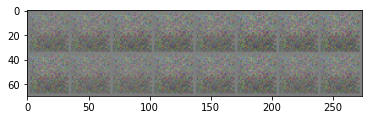

Avg Loss D=0.106690, Avg Loss G=5.750045


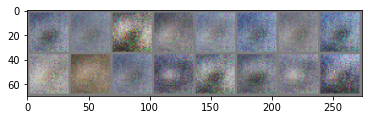

Avg Loss D=0.313257, Avg Loss G=3.895834


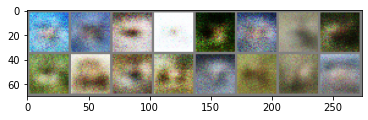

Avg Loss D=0.581799, Avg Loss G=2.659764


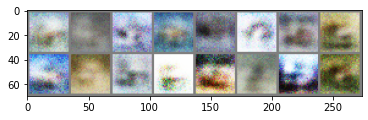

Avg Loss D=0.858644, Avg Loss G=1.766446


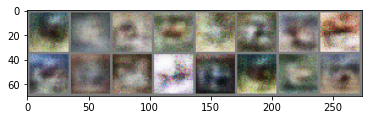

Avg Loss D=1.051777, Avg Loss G=1.295828


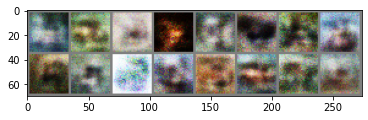

Avg Loss D=1.084102, Avg Loss G=1.203972


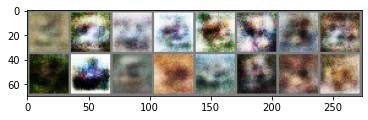

Avg Loss D=1.159683, Avg Loss G=1.054499


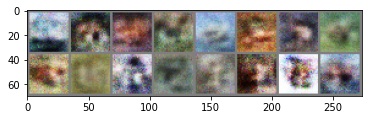

Avg Loss D=1.189008, Avg Loss G=0.995696


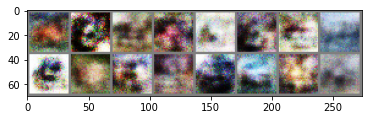

Avg Loss D=1.220935, Avg Loss G=0.948038


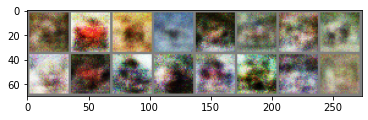

Avg Loss D=1.236139, Avg Loss G=0.914641


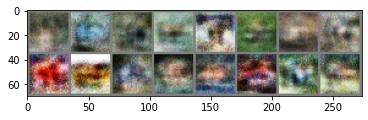

In [22]:
if(__name__=="__main__"):

    root_dir = "/gdrive/My Drive/colab/gan/mnist"
    output_dir = os.path.join(root_dir, "output") # G
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"model_name":"epoch_{0:d}.pt".format(10),
              "root_dir":root_dir,
              "output_dir":output_dir,
              "d_input_node": 3072, # 3*32*32
              "d_hidden_node": 256,
              "d_output_node":1, # 0이나 1이냐인데 1로
              "g_input_node":100,
              "g_hidden_node":256,
              "g_output_node":3072,
              "learn_rate":0.0002,
              "batch_size":100,
              "epoch":100,
              }

    # test는 없음
    train(config)

    # noise에서 점점 이미지가 손글씨 형태를 갖춤
    # 여기서 더 control하고 싶으면 CGAN
    # text 생성하고 싶을 때는 transformer, 이미지 생성하고 싶을 때는 GAN